In [24]:
from physics import (
    A_func, 
    b_func,
    Q_func,
    foot_pos_func,
    foot_vel_func,
    foot_J_func,
    dynamics,
    contact,
)
from drawing import animate_robot

import casadi as ca

from einops import rearrange, einsum

import numpy as np

from IPython.display import HTML

import matplotlib
import matplotlib.pyplot as plt

import sys
import os

%matplotlib inline

# Let's define some simulation parameters

In [2]:
# Define params
m_b = 1.0
I = 0.1
m_l = 0.1
g = 9.81
params = np.array([m_b, I, m_l, g])

# Initial conditions
init_q = np.array([-np.pi/2 - 0.2, 0, 1.5, 0])
init_qd = np.array([0.0, 0, 0, 0])

# Now lets actually go ahead and run the simulation

In [3]:
qs = [init_q]
qds = [init_qd]

end_t = 10.0
time_step = 0.005

steps = int(end_t / time_step)

for i in range(steps):
    # Define PD control
    axis_pos = np.array([qs[-1][0], qs[-1][3]])
    axis_vel = np.array([qds[-1][0], qds[-1][3]])
    axis_target = np.array([-np.pi / 2, 0])
    axis_err = axis_target - axis_pos
    dp = np.array([5.0, 50.0])
    dd = np.array([-1.0, -5.0])
    u = dp * axis_err + dd * axis_vel

    qdd = dynamics(qs[-1], qds[-1], u, params)
    new_qd = qds[-1] + qdd.squeeze() * time_step
    new_q = qs[-1] + new_qd * time_step

    contact_update, hit = contact(new_q, new_qd, params)
    if hit:
        new_qd += contact_update.squeeze()
        new_q = qs[-1] + new_qd * time_step

    qds.append(new_qd)
    qs.append(new_q)

In [4]:
fps = 60
n_frames = int(end_t * fps)
stride = int(len(qs) / n_frames)

list(range(100))[::stride]
1 / fps

anim = animate_robot(qs[::stride], 1000 / fps)
plt.close()
HTML(anim.to_html5_video())

# Ok now let's set up the trajectory optimization problem

## First we have to make reference trajectories

In [5]:
def make_single_hop_reference_trajectory_flex(
    q_init,
    qd_init,
    hop_length,
    air_time,
    contact_height=1.0,
    bottom_height=0.6,
    dt=0.005,
):
    # Set up variables
    A = A_func(q_init, qd_init, params)
    b = b_func(q_init, qd_init, params)
    Q = Q_func(q_init, qd_init, u)

    cur_theta = q_init[0] + np.pi
    cur_omega = qd_init[0]
    cur_pos = np.array([q_init[1], q_init[2]])
    cur_vel = np.array([qd_init[1], qd_init[2]])

    launch_hvel = hop_length / air_time

    # let's calculate our approximate landing position
    foot_space_height = contact_height
    cur_hpos = cur_pos[0]
    cur_vpos = cur_pos[1]
    cur_hvel = cur_vel[0]
    cur_vvel = cur_vel[1]

    landing_time = 0.0
    landing = cur_vpos > foot_space_height
    decelerating = cur_vvel < 0.0 or landing

    landing_hvel = cur_hvel

    if landing:
        # Now let's compute our landing time (when we are foot_space_height above the ground)
        first_part = -cur_vvel
        second_part = np.sqrt(
            cur_vvel**2 - 4 * (g / 2) * (foot_space_height - cur_vpos)
        )
        landing_time = (first_part - second_part) / (-g)

        target_theta_time = landing_time
        # Let's check if we are above 1.75 foot_space_height
        if landing_time > 0.1:
            # If we are, let's try to be at the landing angle by the pre-landing time instead
            # Hopefully this will give us better angular velocity when we land
            target_theta_time = landing_time - 0.05

        # Now let's compute our landing angle
        landing_hvel = cur_hvel
        landing_vvel = cur_vvel - g * landing_time
        landing_vel = np.array([landing_hvel, landing_vvel])
        landing_angle = np.arctan2(landing_vvel, landing_hvel) + np.pi

        # Let's compute the angular velocity we need to reach the landing angle by the target time
        omega_des = (landing_angle - cur_theta) / target_theta_time

        # Landing com pos
        landing_com_pos = np.array(
            [
                cur_hpos + cur_hvel * landing_time,
                foot_space_height,
            ]
        )
    else:
        contact = True
        landing_vvel = cur_vvel
        landing_vel = cur_vel
        landing_angle = cur_theta
        landing_time = 0.0
        landing_com_pos = np.array([cur_hpos, cur_vpos])

    # Now let's compute our launch angle
    launch_vvel = g * air_time / 2  # + foot_space_height
    launch_vel = np.array([launch_hvel, launch_vvel])
    launch_angle = np.arctan2(launch_vvel, launch_hvel)

    contact_vdec = landing_vvel**2 / 2 / (contact_height - bottom_height)
    dec_time = (
        0.0
        if landing_vvel == 0.0
        else 2 * (bottom_height - contact_height) / landing_vvel
    )
    if cur_vpos < contact_height:
        if cur_vpos > bottom_height:
            min_vdec = 2.5
            contact_vdec = landing_vvel**2 / 2 / (cur_vpos - bottom_height)
            contact_vdec = np.clip(contact_vdec, min_vdec, np.inf)
            # dec_time = (
            #     0.0
            #     if landing_vvel == 0.0
            #     else 2 * (bottom_height - cur_vpos) / landing_vvel
            # )
            dec_time = -landing_vvel / contact_vdec
        else:
            max_decc = 10.0
            dec_time = np.abs(cur_vvel / max_decc)
            contact_vdec = max_decc

    mid_stance_com_vvel = landing_vvel + contact_vdec * dec_time
    mid_stance_com_vpos = (
        landing_com_pos[1]
        + landing_vvel * dec_time
        + 0.5 * contact_vdec * dec_time**2
    )

    if not decelerating:
        bottom_height = cur_vpos
        dec_time = 0.0
        mid_stance_com_vvel = cur_vvel
        mid_stance_com_vpos = cur_vpos

    acc_time = (
        2 * (contact_height - mid_stance_com_vpos) / (launch_vvel + mid_stance_com_vvel)
    )
    contact_vacc = (
        (launch_vvel**2 + mid_stance_com_vvel**2)
        / 2
        / (contact_height - mid_stance_com_vpos)
    )

    contact_hacc = (launch_hvel - landing_hvel) / (dec_time + acc_time)
    mid_stance_com_hpos = (
        landing_com_pos[0]
        + landing_hvel * dec_time
        + 0.5 * contact_hacc * dec_time**2
    )
    contact_dec = np.array([contact_hacc, contact_vdec])
    contact_acc = np.array([contact_hacc, contact_vacc])
    mid_stance_com_pos = np.array([mid_stance_com_hpos, mid_stance_com_vpos])

    mid_stance_com_vel = landing_vel + contact_dec * dec_time

    # Now let's compute the launching com pos

    launch_com_pos = (
        mid_stance_com_pos
        + mid_stance_com_vel * acc_time
        + 0.5 * contact_acc * acc_time**2
    )

    # Now let's actually build the trajectory
    interp_time_step = dt
    interp_steps = int(
        (dec_time + acc_time + air_time + landing_time) / interp_time_step
    )
    interp_step_times = np.arange(interp_steps) * interp_time_step

    traj = np.zeros((interp_steps, 6))

    pre_contact_cutoff = int(landing_time / interp_time_step)

    pre_contact_times = interp_step_times[:pre_contact_cutoff]

    if landing:
        # Pre-contact flight phase
        # Set the angular position before contact
        traj[:pre_contact_cutoff, 0] = (
            np.where(
                pre_contact_times < target_theta_time,
                cur_theta + omega_des * pre_contact_times,
                landing_angle,
            )
            - np.pi
        )
        # Set the angular velocity before contact
        traj[:pre_contact_cutoff, 3] = np.where(
            pre_contact_times < target_theta_time,
            omega_des,
            0,
        )
        # Set the horizontal position before contact
        traj[:pre_contact_cutoff, 1] = cur_hpos + cur_hvel * pre_contact_times
        # Set the horizontal velocity before contact
        traj[:pre_contact_cutoff, 4] = cur_hvel
        # Set the vertical position before contact
        traj[:pre_contact_cutoff, 2] = (
            cur_vpos + cur_vvel * pre_contact_times - 0.5 * g * pre_contact_times**2
        )
        # Set the vertical velocity before contact
        traj[:pre_contact_cutoff, 5] = cur_vvel + g * pre_contact_times

    # Contact deceleration phase
    contact_acc_time = landing_time + dec_time
    contact_dec_cutoff = int(contact_acc_time / interp_time_step)
    contact_cutoff = int((contact_acc_time + acc_time) / interp_time_step)
    contact_dec_times = interp_step_times[pre_contact_cutoff:contact_dec_cutoff]

    contact_dec_vels = (
        landing_vel + contact_dec * (contact_dec_times - landing_time)[:, None]
    )
    # Set the contact dec xy velocities
    traj[pre_contact_cutoff:contact_dec_cutoff, 4:6] = contact_dec_vels

    # set the contact dec xy positions
    stance_dec_com_xy_pos = (
        landing_com_pos
        + landing_vel * (contact_dec_times - landing_time)[:, None]
        + 0.5 * contact_dec * (contact_dec_times - landing_time)[:, None] ** 2
    )
    traj[pre_contact_cutoff:contact_dec_cutoff, 1:3] = stance_dec_com_xy_pos

    # Contact acceleration phase
    contact_acc_times = interp_step_times[contact_dec_cutoff:contact_cutoff]
    contact_acc_vels = (
        mid_stance_com_vel
        + contact_acc * (contact_acc_times - contact_acc_time)[:, None]
    )
    contact_acc_com_xy_pos = (
        mid_stance_com_pos
        + mid_stance_com_vel * (contact_acc_times - contact_acc_time)[:, None]
        + 0.5 * contact_acc * (contact_acc_times - contact_acc_time)[:, None] ** 2
    )

    # set the contact acc xy velocities
    traj[contact_dec_cutoff:contact_cutoff, 4:6] = contact_acc_vels
    # set the contact acc xy positions
    traj[contact_dec_cutoff:contact_cutoff, 1:3] = contact_acc_com_xy_pos

    # Concat the stance phase
    stance_com_xy_pos = np.concatenate(
        [stance_dec_com_xy_pos, contact_acc_com_xy_pos], axis=0
    )
    contact_vels = np.concatenate([contact_dec_vels, contact_acc_vels], axis=0)

    launch_time = contact_acc_time + acc_time

    # set the contact theta
    # calculate contact foot pos
    q_land = np.array([landing_angle + np.pi, *landing_com_pos, 0])
    contact_point_pos = foot_pos_func(q_land)
    # Calculate relative foot pos over stance phase
    contact_point_rel_pos = stance_com_xy_pos - contact_point_pos.T
    # Calculate angles
    contact_point_angles = np.arctan2(
        contact_point_rel_pos[:, 1], contact_point_rel_pos[:, 0]
    )
    traj[pre_contact_cutoff:contact_cutoff, 0] = contact_point_angles - np.pi

    # set the contact theta dot
    (stance_theta_dot,) = (np.cross(contact_point_rel_pos, contact_vels, axis=-1),)
    traj[pre_contact_cutoff:contact_cutoff, 3] = stance_theta_dot

    # Flight phase
    flight_times = interp_step_times[contact_cutoff:]

    # Flight angular velocity
    flight_end_theta = -launch_angle + np.pi
    if len(contact_point_angles) > 0:
        flight_start_theta = contact_point_angles[-1]
    else:
        flight_start_theta = cur_theta

    flight_omega = (flight_end_theta - flight_start_theta) / air_time
    flight_acc = np.array([0, -g])

    # set the flight theta
    traj[contact_cutoff:, 0] = (
        flight_start_theta + flight_omega * (flight_times - launch_time) - np.pi
    )

    # set the flight theta dot
    traj[contact_cutoff:, 3] = flight_omega

    if contact_cutoff > 0:
        # set the flight xy pos
        traj[contact_cutoff:, 1:3] = (
            traj[contact_cutoff - 1, 1:3]
            + launch_vel * (flight_times - launch_time)[:, None]
            + 0.5 * flight_acc * (flight_times - launch_time)[:, None] ** 2
        )
        # set the flight xy vel
        traj[contact_cutoff:, 4:6] = (
            launch_vel + flight_acc * (flight_times - launch_time)[:, None]
        )
    else:
        traj[contact_cutoff:, 1:3] = (
            cur_pos
            + launch_vel * (flight_times - launch_time)[:, None]
            + 0.5 * flight_acc * (flight_times - launch_time)[:, None] ** 2
        )
        # set the flight xy vel
        traj[contact_cutoff:, 4:6] = (
            cur_vel + flight_acc * (flight_times - launch_time)[:, None]
        )

    contact = np.zeros((interp_steps, 1), dtype=bool)
    contact[pre_contact_cutoff:contact_cutoff] = True
    return traj, contact

# Test the reference trajectory generator starting from flight conditions

In [6]:
init_q = np.array([-np.pi/2 - 0.2, 0, 2.0, 0])
init_qd = np.array([0.0, -0.5, 0, 0])

ref_traj = make_single_hop_reference_trajectory_flex(
    init_q, init_qd, 0.1, 1.0, contact_height=1.0, bottom_height=0.9, dt=0.01
)[0]

thetas = ref_traj[:, 0]
xs = ref_traj[:, 1]
ys = ref_traj[:, 2]
ls = np.zeros_like(xs)

ref_qs = np.stack([thetas, xs, ys, ls], axis=-1)

In [7]:
anim = animate_robot(ref_qs, 1000 / fps)
HTML(anim.to_html5_video())

# Test the reference trajectory generator starting from a stance phase accelerating

In [8]:
init_q = np.array([-np.pi / 2 - 0.2, 0, 0.5, 0])
init_qd = np.array([0.0, 0.01, 0.05, 0])

ref_traj = make_single_hop_reference_trajectory_flex(
    init_q, init_qd, 0.1, 2.5, contact_height=1.0, bottom_height=0.9, dt=0.01
)[0]

thetas = ref_traj[:, 0]
xs = ref_traj[:, 1]
ys = ref_traj[:, 2]
ls = np.zeros_like(xs)

ref_qs = np.stack([thetas, xs, ys, ls], axis=-1)

In [9]:
anim = animate_robot(ref_qs, 1000 / fps)
HTML(anim.to_html5_video())

# Now a stance phase decelerating

In [10]:
init_q = np.array([-np.pi / 2 - 0.2, 0, 0.5, 0])
init_qd = np.array([0.0, 0, -5.0, 0])

ref_traj = make_single_hop_reference_trajectory_flex(
    init_q, init_qd, 0.1, 2.5, contact_height=1.0, bottom_height=0.9, dt=0.01
)[0]

thetas = ref_traj[:, 0]
xs = ref_traj[:, 1]
ys = ref_traj[:, 2]
ls = np.zeros_like(xs)

ref_qs = np.stack([thetas, xs, ys, ls], axis=-1)

In [11]:
anim = animate_robot(ref_qs, 1000 / fps)
HTML(anim.to_html5_video())

# Now let's define the controller

In [25]:
def optimize_traj(init_q, init_qd, ref_traj, stance, dt=0.005):
    # Find the first stance phase
    stance_start = np.min(np.argwhere(stance.squeeze()))
    stance_end = (
        np.min(np.argwhere(~stance[stance_start:].squeeze())) + stance_start + 1
    )
    # Grab just the first stance phases
    stance = np.zeros_like(stance.squeeze())
    stance[stance_start:stance_end] = True
    n_stance_control_times = np.sum(stance)

    # Extract x and ys from ref_traj
    (
        thetas,
        xs,
        ys,
        theta_dotx,
        x_dots,
        y_dots,
    ) = ref_traj.T
    x_ref = rearrange(ref_traj[stance], "t i -> (t i)")
    x_0 = np.concatenate([init_q[0:3], init_qd[0:3]])
    ls = np.zeros_like(xs)
    qs = np.stack([thetas, xs, ys, ls], axis=-1)

    # Construct A_qp and B_qp
    eye = np.eye(3)
    zero = np.zeros((3, 3))
    A = rearrange(
        np.stack(
            [
                [eye, eye * dt],
                [zero, eye],
            ]
        ),
        "br bc i j -> (br i) (bc j)",
        **{"br": 2, "bc": 2},
    )

    m_inv = np.diag([1 / I, 1 / (m_b + m_l), 1 / (m_b + m_l)])
    M_inv = rearrange(
        np.stack(
            [
                [zero, zero],
                [zero, m_inv],
            ]
        ),
        "br bc i j -> (br i) (bc j)",
        **{"br": 2, "bc": 2},
    )

    jacs = np.stack([foot_J_func(q).T[0:3] for q in qs[stance]])

    J = np.concatenate(
        [
            np.broadcast_to(
                np.zeros([3, 2]),
                jacs.shape,
            ),
            jacs,
        ],
        axis=1,
    )

    bs = np.concatenate([einsum(M_inv, J, "i j, t j k -> t i k")]) * dt

    A_qp_stack = np.stack(
        [np.linalg.matrix_power(A, i) for i in range(n_stance_control_times)]
    )
    A_qp = rearrange(A_qp_stack, "p i j -> (p i) j")
    A_qp_pad = np.concatenate([np.zeros([1, 6, 6]), A_qp_stack])

    A_ind_mat = np.clip(
        np.arange(n_stance_control_times, 0, -1)[None, :]
        - np.arange(n_stance_control_times, 0, -1)[:, None],
        0,
        None,
    )

    A_qp_mat = A_qp_pad[A_ind_mat]

    B_qp = einsum(A_qp_mat, bs, "bi bj i j, bj j k -> bi bj i k")
    B_qp = rearrange(B_qp, "bi bj i j -> (bi i) (bj j)")

    # Weight Matrix
    # TODO: Tune this
    L = np.kron(
        np.diag(np.arange(n_stance_control_times)),
        np.diag(np.array([0.0, 1.0, 1.0, 0.0, 250.0, 250.0])),
    )
    K = np.eye(n_stance_control_times * 2) * 1e-2

    H = 2 * (B_qp.T @ L @ B_qp + K)
    g = 2 * B_qp.T @ L @ (A_qp @ x_0 - x_ref)

    # Constraints
    c_single = np.array(
        [
            [0, 1],  # No pulling constraint
            [-1.0, 0.4],  # Friction cone constraint
            [1.0, 0.4],  # Friction cone constraint
        ]
    )
    c_lower_single = np.array(
        [
            [0.05],  # No pulling constraint
            [0],  # Friction cone constraint
            [0],  # Friction cone constraint
        ]
    )

    C = np.kron(np.eye(n_stance_control_times), c_single)
    c_lower = np.tile(c_lower_single, (n_stance_control_times, 1))

    # Silence casadi
    stdout = sys.stdout
    stderr = sys.stderr
    sys.stdout = sys.stderr = open(os.devnull, "w")
    # Define optimization variables
    U = ca.MX.sym("U", n_stance_control_times * 2)

    # Solve QP
    H_ca = ca.DM(H)
    g_ca = ca.DM(g)
    C_ca = ca.DM(C)
    c_lower_ca = ca.DM(c_lower)

    # Cost
    cost = 0.5 * ca.mtimes(U.T, ca.mtimes(H_ca, U)) + ca.mtimes(g_ca.T, U)

    # Solver
    qp = {"x": U, "f": cost, "g": ca.vertcat(C_ca @ U)}
    opts = {"print_time": 0, "printLevel": "none", "verbose": False}
    solver = ca.qpsol("solver", "qpoases", qp, opts)

    # Solve the QP
    res = solver(lbg=c_lower_ca, ubg=ca.inf)
    U_opt = res["x"]

    # Un-silence casadi
    sys.stdout = stdout
    sys.stderr = stderr

    return U_opt

# let's try and run the controller

In [26]:
init_q = np.array([-np.pi / 2 - 0.2, 0, 1.5, 0])
init_qd = np.array([0.0, 0, 0, 0])

ref_traj, stance = make_single_hop_reference_trajectory_flex(
    init_q, init_qd, 0.1, 0.5, contact_height=1.0, bottom_height=0.9, dt=0.01
)

thetas = ref_traj[:, 0]
xs = ref_traj[:, 1]
ys = ref_traj[:, 2]
ls = np.zeros_like(xs)

ref_qs = np.stack([thetas, xs, ys, ls], axis=-1)

soln = optimize_traj(init_q, init_qd, ref_traj, stance, dt=0.01)
print(f"Control: {soln}")

Control: [0.02, 0.05, 0.02, 0.05, 0.02, 0.05, 0.02, 0.05, 0.02, 0.05, 0.02, 0.05, 0.02, 0.05, 9.29553, 23.2388, 2.71681, 32.2388, 1.57184, 33.0445, 1.51561, 33.0835, 1.51313, 33.0855, 1.5137, 33.1049, 1.53298, 33.674, 2.13162, 51.3482, 0, 0.05]


In [27]:
init_q = np.array([-np.pi / 2, 0, 5.0, 0])
init_qd = np.array([0.0, 0, 0, 0])

qs = [init_q]
qds = [init_qd]

end_t = 20.0
time_step = 0.005
optim_dt = 0.025
traj_substep = 10

steps = int(end_t / time_step)

stance_height = 1.0

debounce_counter = 0
debounce_thold = 5
bounce_counter = 0
standing = False
bounce_idxs = []
bounce_targets = []

# hop_lens = [0.0, 0.5, 0.0, 0.0, -0.5, 0.0, 0.0]
hop_lens = [0.0, -0.5, -0.5, -0.0, 0.25, 0.0, 1.0]

for i in range(steps):
    # print(i)
    hop_len = hop_lens[bounce_counter % len(hop_lens)]
    ref_traj, stance = make_single_hop_reference_trajectory_flex(
        qs[-1],
        qds[-1],
        hop_len,
        1.5,
        contact_height=stance_height,
        bottom_height=0.6,
        dt=optim_dt / traj_substep,
    )

    # Define PD control
    axis_pos = np.array([qs[-1][0], qs[-1][3]])
    axis_vel = np.array([qds[-1][0], qds[-1][3]])
    axis_target = np.array([ref_traj[0, 0], 0.0])
    axis_perr = axis_target - axis_pos
    axis_verr = np.array([ref_traj[0][3], 0.0]) - axis_vel
    axis_verr = axis_verr

    dp = np.array([5.0, 5.0])
    dd = np.array([1.0, 1.0])
    u = dp * axis_perr + dd * axis_verr

    if stance[0]:
        # print(f"hi: {i}")
        # We are in stance, use the control
        # Reach out and make contact

        # print("hmm")

        ref_traj = ref_traj[::traj_substep]
        stance = stance[::traj_substep]
        soln = optimize_traj(qs[-1], qds[-1], ref_traj, stance, dt=optim_dt)
        soln = np.array(
            soln
        ).squeeze()  # This is the commanded reaction force from the foot.

        foot_jac_t = foot_J_func(qs[-1]).T[[0, 3]]
        u = foot_jac_t @ (-soln[0:2] - np.array([0, g]) * (m_b + m_l))

        pass
        # print("bye")

    M = A_func(qs[-1], qds[-1], params)
    M_inv = np.linalg.inv(M)
    qdd = dynamics(qs[-1], qds[-1], u, params)
    new_qd = qds[-1] + qdd.squeeze() * time_step
    new_q = qs[-1] + new_qd * time_step

    contact_update, hit = contact(new_q, new_qd, params)
    if hit:
        if not standing:
            debounce_counter += 1
        else:
            debounce_counter = 0
        if debounce_counter >= debounce_thold:
            standing = True
            debounce_counter = 0

            bounce_counter += 1
            print(f"Bounce: {bounce_counter}")
            bounce_idxs.append(i)
            bounce_targets.append(hop_lens[bounce_counter % len(hop_lens)])

        new_qd += contact_update.squeeze()
        new_q = qs[-1] + new_qd * time_step
    else:
        if standing:
            debounce_counter += 1
        else:
            debounce_counter = 0
        if debounce_counter >= debounce_thold:
            standing = False
            debounce_counter = 0

    qds.append(new_qd)
    qs.append(new_q)

Bounce: 1
Bounce: 2
Bounce: 3
Bounce: 4
Bounce: 5
Bounce: 6
Bounce: 7
Bounce: 8
Bounce: 9
Bounce: 10
Bounce: 11
Bounce: 12
Bounce: 13


In [28]:
print(f"num_bounces: {len(bounce_idxs)}")
print(f"bounce targets: {bounce_targets}")

num_bounces: 13
bounce targets: [-0.5, -0.5, -0.0, 0.25, 0.0, 1.0, 0.0, -0.5, -0.5, -0.0, 0.25, 0.0, 1.0]


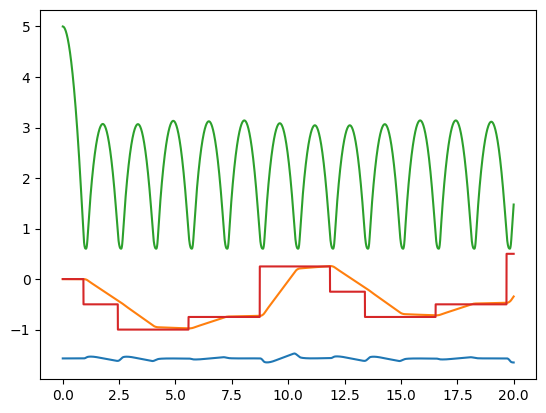

In [29]:
qs_np = np.stack(qs, axis=0)
ts = np.arange(len(qs_np)) * time_step
plt.plot(ts, qs_np[:, 0], label="theta")
plt.plot(ts, qs_np[:, 1], label="x")
plt.plot(ts, qs_np[:, 2], label="y")

# Plot the target positions from the hop_lens
bounce_goal = np.zeros_like(ts).squeeze()
bounce_goal[np.array(bounce_idxs, dtype=np.int32)] = bounce_targets
goal = np.cumsum(bounce_goal)
plt.plot(ts, goal, label="goal")

In [30]:
mean_air_time = np.mean(np.diff(np.array(bounce_idxs) * time_step))
print(f"Mean air time: {mean_air_time}\nTarget air time: {1.5}")

Mean air time: 1.56375
Target air time: 1.5


In [31]:
fps = 60
n_frames = int(end_t * fps)
stride = int(len(qs) / n_frames)

list(range(100))[::stride]
1 / fps

anim = animate_robot(qs[::stride], 1000 / fps)
plt.close()
HTML(anim.to_html5_video())